<a href="https://colab.research.google.com/github/20WH1A6637/MarchMachineLearningMania2021/blob/main/MarchMachineLearningMania2021Stage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import log_loss
import lightgbm as lgb

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/MarchMachineLearningMania2021/ncaam-march-mania-2021 (1)/MDataFiles_Stage2'
STAGE_1 = False

In [ ]:
MRSCResults = pd.read_csv(data + '/MRegularSeasonCompactResults.csv')
MRSCResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
170730,2021,132,1382,74,1433,65,N,0
170731,2021,132,1159,85,1259,72,H,0
170732,2021,132,1104,80,1261,79,N,0
170733,2021,132,1222,91,1153,54,N,0


In [ ]:
A_w = MRSCResults[MRSCResults.WLoc == 'A']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_A"})
print(A_w.head())
N_w = MRSCResults[MRSCResults.WLoc == 'N']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_N"})
H_w = MRSCResults[MRSCResults.WLoc == 'H']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_H"})
win = A_w.join(N_w, how='outer').join(H_w, how='outer').fillna(0)

H_l = MRSCResults[MRSCResults.WLoc == 'A']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_H"})
N_l = MRSCResults[MRSCResults.WLoc == 'N']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_N"})
A_l = MRSCResults[MRSCResults.WLoc == 'H']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_A"})
lost = A_l.join(N_l, how='outer').join(H_l, how='outer').fillna(0)
print(win)
print(lost)
win.index = win.index.rename(['Season', 'TeamID'])
lost.index = lost.index.rename(['Season', 'TeamID'])
wl = win.join(lost, how='outer').reset_index()
print(wl)
wl['win_pct_A'] = wl['win_A'] / (wl['win_A'] + wl['lost_A'])
wl['win_pct_N'] = wl['win_N'] / (wl['win_N'] + wl['lost_N'])
wl['win_pct_H'] = wl['win_H'] / (wl['win_H'] + wl['lost_H'])
wl['win_pct_All'] = (wl['win_A'] + wl['win_N'] + wl['win_H']) / \
    (wl['win_A'] + wl['win_N'] + wl['win_H'] + wl['lost_A']\
     + wl['lost_N'] + wl['lost_H'])
print(wl)
del A_w, N_w, H_w, H_l, N_l, A_l, win, lost

                win_A
Season WTeamID       
1985   1102         3
       1103         2
       1104         5
       1106         1
       1108         8
                win_A  win_N  win_H
Season WTeamID                     
1985   1102       3.0    0.0    2.0
       1103       2.0    0.0    7.0
       1104       5.0    1.0   15.0
       1106       1.0    1.0    8.0
       1108       8.0    3.0    8.0
...               ...    ...    ...
2021   1467       3.0    0.0    6.0
       1468       7.0    0.0    4.0
       1469       3.0    0.0    3.0
       1470       4.0    0.0    1.0
       1471       0.0    0.0    4.0

[11926 rows x 3 columns]
                lost_A  lost_N  lost_H
Season LTeamID                        
1985   1102        9.0     2.0     8.0
       1103        8.0     0.0     6.0
       1104        6.0     2.0     1.0
       1106       10.0     3.0     1.0
       1108        4.0     1.0     1.0
...                ...     ...     ...
2021   1467        6.0     0.0     3.0
 

In [ ]:
MRSCResults['relScore'] = MRSCResults.WScore - MRSCResults.LScore

w_scr = MRSCResults.loc[:, ['Season', 'WTeamID', 'WScore', 'WLoc','relScore']]
w_scr.columns = ['Season', 'TeamID', 'Score', 'Loc', 'relScore']
#print(w_scr)
l_scr = MRSCResults.loc[:, ['Season', 'LTeamID', 'LScore', 'WLoc','relScore']]
#print(l_scr)
l_scr['WLoc'] = l_scr.WLoc.apply(lambda x: 'H' if x == 'A' else 'A' if x == 'H' else 'N')
l_scr['relScore'] = -1 * l_scr.relScore 
l_scr.columns = ['Season', 'TeamID','Score','Loc','relScore']
#print(l_scr)
wl_scr = pd.concat([w_scr,l_scr])
#print(wl_scr)
A_scr = wl_scr[wl_scr.Loc == 'A'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_A", "relScore": "relScore_A"})
#print(A_scr)
N_scr = wl_scr[wl_scr.Loc == 'N'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_N", "relScore": "relScore_N"})
H_scr = wl_scr[wl_scr.Loc == 'H'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_H", "relScore": "relScore_H"})
All_scr = wl_scr.groupby(['Season','TeamID'])['Score','relScore']\
    .mean().rename(columns={"Score": "Score_All", "relScore": "relScore_All"})
scr = A_scr.join(N_scr, how='outer').join(H_scr, how='outer')\
    .join(All_scr, how='outer').fillna(0).reset_index()
print(scr)
del w_scr, l_scr, wl_scr, A_scr, H_scr, N_scr, All_scr

       Season  TeamID    Score_A  relScore_A  Score_N  relScore_N    Score_H  \
0        1985    1102  62.833333   -8.166667    55.50  -12.500000  64.900000   
1        1985    1103  60.800000   -8.300000     0.00    0.000000  61.230769   
2        1985    1104  65.181818    4.000000    53.00   -0.333333  73.687500   
3        1985    1106  72.272727   -7.272727    64.50  -14.000000  74.000000   
4        1985    1108  78.583333    1.583333    77.75    5.250000  91.222222   
...       ...     ...        ...         ...      ...         ...        ...   
11936    2021    1467  62.555556   -1.555556     0.00    0.000000  70.000000   
11937    2021    1468  75.888889    7.444444    70.00   -3.000000  69.125000   
11938    2021    1469  72.222222  -12.333333     0.00    0.000000  63.500000   
11939    2021    1470  65.727273   -2.909091     0.00    0.000000  58.750000   
11940    2021    1471  57.714286  -16.571429     0.00    0.000000  79.571429   

       relScore_H  Score_All  relScore_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
MRSDetailedResults = pd.read_csv(data + '/MRegularSeasonDetailedResults.csv')
MRSDetailedResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96682,2021,132,1104,80,1261,79,N,0,33,76,...,27,9,13,15,26,10,5,6,5,13
96683,2021,132,1159,85,1259,72,H,0,31,59,...,22,9,16,12,19,12,12,2,1,13
96684,2021,132,1222,91,1153,54,N,0,37,66,...,33,10,15,14,17,11,10,2,5,12
96685,2021,132,1228,91,1326,88,N,1,29,64,...,25,22,30,8,27,11,8,7,4,26


In [ ]:
w = MRSDetailedResults.loc[:, ['Season', 'WTeamID', 'WFGM','WFGA','WFGM3'
                               ,'WFGA3','WFTM','WFTA','WOR','WDR','WAst',
                               'WTO','WStl','WBlk','WPF']]
w.columns = ['Season', 'TeamID', 'FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR',
             'Ast','TO','Stl','Blk','PF']
#print(w)
l = MRSDetailedResults.loc[:, ['Season', 'LTeamID', 'LFGM','LFGA','LFGM3',
                               'LFGA3','LFTM','LFTA','LOR','LDR','LAst',
                               'LTO','LStl','LBlk','LPF']]
l.columns = ['Season', 'TeamID', 'FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR',
             'Ast','TO','Stl','Blk','PF']

detail = pd.concat([w,l])
#print(detail)
detail['goal_rate'] = detail.FGM / detail.FGA 
detail['3p_goal_rate'] = detail.FGM3 / detail.FGA3  
detail['ft_goal_rate'] = detail.FTM  / detail.FTA  

dt = detail.groupby(['Season','TeamID'])['FGM','FGA','FGM3','FGA3','FTM','FTA',
                                         'OR','DR','Ast','TO','Stl','Blk','PF',
                                          'goal_rate', '3p_goal_rate',
                                         'ft_goal_rate']\
                                        .mean().fillna(0).reset_index()
print(dt)

del w, l, detail

      Season  TeamID        FGM        FGA       FGM3       FGA3        FTM  \
0       2003    1102  19.142857  39.785714   7.821429  20.821429  11.142857   
1       2003    1103  27.148148  55.851852   5.444444  16.074074  19.037037   
2       2003    1104  24.035714  57.178571   6.357143  19.857143  14.857143   
3       2003    1105  24.384615  61.615385   7.576923  20.769231  15.423077   
4       2003    1106  23.428571  55.285714   6.107143  17.642857  10.642857   
...      ...     ...        ...        ...        ...        ...        ...   
6529    2021    1467  24.111111  53.722222   7.000000  22.111111  11.055556   
6530    2021    1468  27.277778  54.500000   6.333333  17.055556  11.666667   
6531    2021    1469  23.368421  57.842105   5.842105  19.684211  15.052632   
6532    2021    1470  22.000000  50.866667   5.466667  14.600000  14.400000   
6533    2021    1471  25.714286  55.928571  10.142857  27.428571   7.071429   

            FTA         OR         DR        Ast   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
MMOrdinals = pd.read_csv(data + '/MMasseyOrdinals.csv')
MMOrdinals

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
4339985,2021,133,WOB,1467,233
4339986,2021,133,WOB,1468,176
4339987,2021,133,WOB,1469,290
4339988,2021,133,WOB,1470,256


In [ ]:
MOR_127_128 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & ((MMOrdinals.RankingDayNum == 127) \
                | (MMOrdinals.RankingDayNum == 128))]\
                [['Season','TeamID','OrdinalRank']]
MOR_50_51 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 50) \
                 | (MMOrdinals.RankingDayNum == 51))]\
                [['Season','TeamID','OrdinalRank']]
MOR_15_16 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 15) \
                 | (MMOrdinals.RankingDayNum == 16))]\
                [['Season','TeamID','OrdinalRank']]

MOR_127_128 = MOR_127_128.rename(columns={'OrdinalRank':'OrdinalRank_127_128'})
#print(MOR_127_128)
MOR_50_51 = MOR_50_51.rename(columns={'OrdinalRank':'OrdinalRank_50_51'})
#print(MOR_50_51)
MOR_15_16 = MOR_15_16.rename(columns={'OrdinalRank':'OrdinalRank_15_16'})
#print(MOR_15_16)
MOR = MOR_127_128.merge(MOR_50_51, how='left', on=['Season','TeamID'])\
        .merge(MOR_15_16, how='left', on=['Season','TeamID'])
#print(MOR)
## normalizing Rank values by its season maxium as it varies by seasons
MOR_max = MOR.groupby('Season')['OrdinalRank_127_128','OrdinalRank_50_51',
                                'OrdinalRank_15_16'].max().reset_index()
MOR_max.columns = ['Season', 'maxRank_127_128', 'maxRank_50_51', 'maxRank_15_16']
#print(MOR_max)

MOR_tmp = MMOrdinals[(MMOrdinals.SystemName == 'MOR') \
                     & (MMOrdinals.RankingDayNum < 133)]
#print(MOR_tmp)
MOR_stats = MOR_tmp.groupby(['Season','TeamID'])['OrdinalRank']\
            .agg(['max','min','std','mean']).reset_index()

MOR_stats.columns = ['Season','TeamID','RankMax','RankMin','RankStd','RankMean']
#print(MOR_stats)
MOR = MOR.merge(MOR_max, how='left', on='Season')\
        .merge(MOR_stats, how='left', on=['Season','TeamID'])
#print(MOR)
MOR['OrdinalRank_127_128'] = MOR['OrdinalRank_127_128'] / MOR['maxRank_127_128']
MOR['OrdinalRank_50_51'] = MOR['OrdinalRank_50_51'] / MOR['maxRank_50_51']
MOR['OrdinalRank_15_16'] = MOR['OrdinalRank_15_16'] / MOR['maxRank_15_16']
MOR['RankTrans_50_51_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_50_51']
MOR['RankTrans_15_16_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_15_16']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [ ]:
wl_1 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                else str(col) for col in wl_1.columns ]
#print(wl_1)

wl_2 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                else str(col) for col in wl_2.columns ]
#print(wl_2)
scr_1 = scr.copy()
scr_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_1.columns ]
#print(scr_1)
scr_2 = scr.copy()
scr_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_2.columns ]
#print(scr_2)
dt_1 = dt.copy()
dt_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_1.columns ]

dt_2 = dt.copy()
dt_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_2.columns ]

MOR_1 = MOR.copy()
MOR_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_1.columns ]

MOR_2 = MOR.copy()
MOR_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_2.columns ]


In [ ]:
TCResults = pd.read_csv(data + '/MNCAATourneyCompactResults.csv')
TCResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1403,61,1277,51,N,0
2249,2019,152,1438,63,1120,62,N,0


In [ ]:
tourney1 = TCResults.loc[:, ['Season','WTeamID','LTeamID']]
tourney1.columns = ['Season','TeamID1','TeamID2']
tourney1['result'] = 1

tourney2 = TCResults.loc[:, ['Season','LTeamID','WTeamID']]
tourney2.columns = ['Season','TeamID1','TeamID2']
tourney2['result'] = 0
print(TCResults)
print(tourney1)
print(tourney2)
tourney = pd.concat([tourney1, tourney2])
print(tourney)
del tourney1, tourney2

      Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0       1985     136     1116      63     1234      54    N      0
1       1985     136     1120      59     1345      58    N      0
2       1985     136     1207      68     1250      43    N      0
3       1985     136     1229      58     1425      55    N      0
4       1985     136     1242      49     1325      38    N      0
...      ...     ...      ...     ...      ...     ...  ...    ...
2246    2019     146     1120      77     1246      71    N      1
2247    2019     146     1277      68     1181      67    N      0
2248    2019     152     1403      61     1277      51    N      0
2249    2019     152     1438      63     1120      62    N      0
2250    2019     154     1438      85     1403      77    N      1

[2251 rows x 8 columns]
      Season  TeamID1  TeamID2  result
0       1985     1116     1234       1
1       1985     1120     1345       1
2       1985     1207     1250       1
3       1985   

In [ ]:
def merge_data(df):

    df = df.merge(wl_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(wl_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)


    df = df.merge(scr_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(scr_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df = df.merge(dt_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(dt_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df = df.merge(MOR_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(MOR_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df['OrdinalRank_127_128_diff'] = df['OrdinalRank_127_128_1'] \
        - df['OrdinalRank_127_128_2']
    
    df['magic1'] = df['OrdinalRank_127_128_diff'] - df['RankMean_1']
    df['magic2'] = df['RankMean_1'] - df['RankMean_2']
    df['magic3'] = df['OrdinalRank_127_128_diff'] - df['RankMean_2']
    
    df['magic11'] = df['OrdinalRank_127_128_diff'] * df['RankMean_1']
    df['magic21'] = df['RankMean_1'] * df['RankMean_2']
    df['magic31'] = df['OrdinalRank_127_128_diff'] * df['RankMean_2']
    
    df['magic12'] = df['OrdinalRank_127_128_diff'] / df['RankMean_1']
    df['magic22'] = df['RankMean_1'] / df['RankMean_2']
    df['magic32'] = df['OrdinalRank_127_128_diff'] / df['RankMean_2']

    df = df.fillna(-1)

    for col in df.columns:
        if (df[col] == np.inf).any() or (df[col] == -np.inf).any():
            df[col][(df[col] == np.inf) | (df[col] == -np.inf)] = -1
    
    return df

tourney = merge_data(tourney)
tourney = tourney.loc[tourney.Season >= 2003,:].reset_index(drop=True)

if STAGE_1:
    tourney = tourney.loc[tourney.Season < 2015, :]

In [ ]:
if STAGE_1:
    MSampleSubmission = pd.read_csv(data + '/MSampleSubmissionStage1.csv')
else:
    MSampleSubmission = pd.read_csv(data + '/MSampleSubmissionStage2.csv') 

test1 = MSampleSubmission.copy()
test1['Season'] = test1.ID.apply(lambda x: int(x[0:4]))
test1['TeamID1'] = test1.ID.apply(lambda x: int(x[5:9]))
test1['TeamID2'] = test1.ID.apply(lambda x: int(x[10:14]))

test2 = MSampleSubmission.copy()
test2['Season'] = test2.ID.apply(lambda x: int(x[0:4]))
test2['TeamID1'] = test2.ID.apply(lambda x: int(x[10:14]))
test2['TeamID2'] = test2.ID.apply(lambda x: int(x[5:9]))

test = pd.concat([test1,test2]).drop(['Pred'], axis=1)
print(test1)
test = merge_data(test)
print(test)

                  ID  Pred  Season  TeamID1  TeamID2
0     2021_1101_1104   0.5    2021     1101     1104
1     2021_1101_1111   0.5    2021     1101     1111
2     2021_1101_1116   0.5    2021     1101     1116
3     2021_1101_1124   0.5    2021     1101     1124
4     2021_1101_1140   0.5    2021     1101     1140
...              ...   ...     ...      ...      ...
2273  2021_1452_1457   0.5    2021     1452     1457
2274  2021_1452_1458   0.5    2021     1452     1458
2275  2021_1455_1457   0.5    2021     1455     1457
2276  2021_1455_1458   0.5    2021     1455     1458
2277  2021_1457_1458   0.5    2021     1457     1458

[2278 rows x 5 columns]
                  ID  Season  TeamID1  TeamID2  win_pct_A_1  win_pct_N_1  \
0     2021_1101_1104    2021     1101     1104     0.555556          1.0   
1     2021_1101_1111    2021     1101     1111     0.555556          1.0   
2     2021_1101_1116    2021     1101     1116     0.555556          1.0   
3     2021_1101_1124    2021     11

In [ ]:
tourney

,Season,TeamID1,TeamID2,result,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,OrdinalRank_127_128_diff,magic1,magic2,magic3,magic11,magic21,magic31,magic12,magic22,magic32
0,2003,1421,1411,1,0.125000,1.000000,0.833333,0.448276,0.333333,0.750000,...,-0.067278,-267.995850,-39.071429,-307.067278,-18.025775,82254.071429,-20.654434,-0.000251,0.872732,-0.000219
1,2003,1112,1436,1,0.916667,0.000000,0.933333,0.892857,0.500000,0.600000,...,-0.565749,-3.280035,-192.785714,-196.065749,-1.535605,530.642857,-110.603976,-0.208434,0.013884,-0.002894
2,2003,1113,1272,1,0.400000,0.500000,0.800000,0.620690,0.636364,1.000000,...,0.006116,-33.708170,-5.500000,-39.208170,0.206204,1322.081633,0.239843,0.000181,0.859745,0.000156
3,2003,1141,1166,1,0.642857,1.000000,0.916667,0.793103,0.636364,1.000000,...,0.100917,-125.184797,106.071429,-19.113368,12.643512,2407.275510,1.939056,0.000805,6.520446,0.005252
4,2003,1143,1301,1,0.636364,0.250000,0.928571,0.724138,0.300000,0.500000,...,-0.003058,-44.931630,14.214286,-30.717344,-0.137396,1379.948980,-0.093927,-0.000068,1.462791,-0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,1246,1120,0,0.800000,0.400000,0.944444,0.818182,0.400000,0.875000,...,-0.005666,-29.450110,22.111111,-7.338999,-0.166824,215.925926,-0.041549,-0.000192,4.015152,-0.000773
2226,2019,1181,1277,0,0.777778,0.875000,0.882353,0.852941,0.666667,0.833333,...,-0.008499,-3.286276,-3.666667,-6.952943,-0.027856,22.762346,-0.059018,-0.002593,0.472000,-0.001224
2227,2019,1277,1403,0,0.666667,0.833333,0.937500,0.823529,0.666667,0.600000,...,-0.002833,-6.947277,-4.777778,-11.725055,-0.019673,81.404321,-0.033207,-0.000408,0.592417,-0.000242
2228,2019,1120,1438,0,0.400000,0.875000,0.875000,0.735294,0.909091,0.800000,...,0.022663,-7.310670,0.888889,-6.421782,0.166195,47.259259,0.146050,0.003090,1.137931,0.003517


In [ ]:
test

,ID,Season,TeamID1,TeamID2,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,OrdinalRank_127_128_diff,magic1,magic2,magic3,magic11,magic21,magic31,magic12,magic22,magic32
0,2021_1101_1104,2021,1101,1104,0.555556,1.0,1.000000,0.826087,0.700000,0.714286,...,0.256484,-82.610183,57.200000,-25.410183,21.253987,2126.911111,6.583093,0.003095,3.228571,0.009993
1,2021_1101_1111,2021,1101,1111,0.555556,1.0,1.000000,0.826087,0.363636,1.000000,...,-0.348703,-83.215370,-129.200000,-212.415370,-28.895869,17573.257778,-73.948319,-0.004208,0.390758,-0.001644
2,2021_1101_1116,2021,1101,1116,0.555556,1.0,1.000000,0.826087,0.555556,0.500000,...,0.253602,-82.613064,64.666667,-17.946398,21.015178,1508.173333,4.615562,0.003060,4.553114,0.013934
3,2021_1101_1124,2021,1101,1124,0.555556,1.0,1.000000,0.826087,0.875000,0.800000,...,0.268012,-82.598655,81.000000,-1.598655,22.209222,154.684444,0.500288,0.003234,44.392857,0.143578
4,2021_1101_1140,2021,1101,1140,0.555556,1.0,1.000000,0.826087,0.777778,0.600000,...,0.178674,-82.687992,30.000000,-52.687992,14.806148,4380.884444,9.445917,0.002156,1.567465,0.003380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,2021_1452_1457,2021,1457,1452,1.000000,1.0,0.916667,0.958333,0.777778,0.600000,...,0.054755,-68.878578,34.600000,-34.278578,3.774448,2366.711111,1.879923,0.000794,2.007767,0.001595
4552,2021_1452_1458,2021,1458,1452,0.454545,0.5,0.687500,0.586207,0.777778,0.600000,...,-0.063401,-12.796734,-21.600000,-34.396734,-0.807301,437.177778,-2.176753,-0.004979,0.370874,-0.001847
4553,2021_1455_1457,2021,1457,1455,1.000000,1.0,0.916667,0.958333,0.714286,0.500000,...,-0.051873,-68.985207,-16.466667,-85.451873,-3.575793,5886.906667,-4.429971,-0.000753,0.807182,-0.000607
4554,2021_1455_1458,2021,1458,1455,0.454545,0.5,0.687500,0.586207,0.714286,0.500000,...,-0.170029,-12.903362,-72.666667,-85.570029,-2.165034,1087.426667,-14.520461,-0.013353,0.149102,-0.001991


In [ ]:
X = tourney.drop(['Season','TeamID1','TeamID2','result'], axis=1)
y = tourney["result"]
s = tourney["Season"]

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)
X_test

,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,win_pct_H_2,win_pct_All_2,Score_A_1,relScore_A_1,...,OrdinalRank_127_128_diff,magic1,magic2,magic3,magic11,magic21,magic31,magic12,magic22,magic32
0,0.555556,1.0,1.000000,0.826087,0.700000,0.714286,0.923077,0.800000,68.666667,1.333333,...,0.256484,-82.610183,57.200000,-25.410183,21.253987,2126.911111,6.583093,0.003095,3.228571,0.009993
1,0.555556,1.0,1.000000,0.826087,0.363636,1.000000,0.555556,0.541667,68.666667,1.333333,...,-0.348703,-83.215370,-129.200000,-212.415370,-28.895869,17573.257778,-73.948319,-0.004208,0.390758,-0.001644
2,0.555556,1.0,1.000000,0.826087,0.555556,0.500000,0.941176,0.785714,68.666667,1.333333,...,0.253602,-82.613064,64.666667,-17.946398,21.015178,1508.173333,4.615562,0.003060,4.553114,0.013934
3,0.555556,1.0,1.000000,0.826087,0.875000,0.800000,1.000000,0.916667,68.666667,1.333333,...,0.268012,-82.598655,81.000000,-1.598655,22.209222,154.684444,0.500288,0.003234,44.392857,0.143578
4,0.555556,1.0,1.000000,0.826087,0.777778,0.600000,0.818182,0.760000,68.666667,1.333333,...,0.178674,-82.687992,30.000000,-52.687992,14.806148,4380.884444,9.445917,0.002156,1.567465,0.003380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,1.000000,1.0,0.916667,0.958333,0.777778,0.600000,0.615385,0.666667,79.700000,13.000000,...,0.054755,-68.878578,34.600000,-34.278578,3.774448,2366.711111,1.879923,0.000794,2.007767,0.001595
4552,0.454545,0.5,0.687500,0.586207,0.777778,0.600000,0.615385,0.666667,66.090909,-0.636364,...,-0.063401,-12.796734,-21.600000,-34.396734,-0.807301,437.177778,-2.176753,-0.004979,0.370874,-0.001847
4553,1.000000,1.0,0.916667,0.958333,0.714286,0.500000,0.800000,0.736842,79.700000,13.000000,...,-0.051873,-68.985207,-16.466667,-85.451873,-3.575793,5886.906667,-4.429971,-0.000753,0.807182,-0.000607
4554,0.454545,0.5,0.687500,0.586207,0.714286,0.500000,0.800000,0.736842,66.090909,-0.636364,...,-0.170029,-12.903362,-72.666667,-85.570029,-2.165034,1087.426667,-14.520461,-0.013353,0.149102,-0.001991


In [ ]:
s.head()

0    2003
1    2003
2    2003
3    2003
4    2003
Name: Season, dtype: int64

In [ ]:
s.value_counts()

2011    134
2012    134
2018    134
2017    134
2016    134
2015    134
2014    134
2013    134
2019    134
2004    128
2010    128
2009    128
2008    128
2007    128
2006    128
2005    128
2003    128
Name: Season, dtype: int64

In [ ]:
len(X_test)

4556

In [ ]:
def model_training(X, y, cv, groups, params, metric, early_stopping=10, \
    plt_iter=True, X_test=[], cat_features=[]):

    feature_importance = pd.DataFrame()
    val_scores=[]
    train_evals=[]
    valid_evals=[]

    if len(X_test) > 0:
        test_pred = np.zeros(len(X_test))

    for idx, (train_index, val_index) in enumerate(cv.split(X, y, groups)):

        print("###### fold %d ######" % (idx+1))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMClassifier(**params)

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping,
                  verbose=20
                  )
        val_scores.append(model.best_score_['valid_1'][metric])
        train_evals.append(model.evals_result_['training'][metric])
        valid_evals.append(model.evals_result_['valid_1'][metric])

        if len(X_test) > 0:
            test_pred = test_pred + model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = idx+1
        feature_importance = pd.concat([feature_importance, fold_importance]
                                       , axis=0)

    if plt_iter:
        
        fig, axs = plt.subplots(2, 2, figsize=(9,6))
        
        for i, ax in enumerate(axs.flatten()):
            ax.plot(train_evals[i], label='training')
            ax.plot(valid_evals[i], label='validation')
            ax.set(xlabel='interations', ylabel=f'{metric}')
            ax.set_title(f'fold {i+1}', fontsize=12)
            ax.legend(loc='upper right', prop={'size': 9})
        fig.tight_layout()
        plt.show()
    
    print('### CV scores by fold ###')
    for i in range(cv.get_n_splits(X)):
        print(f'fold {i+1}: {val_scores[i]:.4f}')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'\
          .format(np.mean(val_scores), np.std(val_scores)))
    
    feature_importance = feature_importance[["feature", "importance"]]\
                         .groupby("feature").mean().sort_values(
                         by="importance", ascending=False)
    feature_importance.reset_index(inplace=True)

    if len(X_test) > 0:
        test_pred = test_pred / cv.get_n_splits(X)
        return feature_importance, test_pred
    else:
        return feature_importance

In [ ]:
lgb_params = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 31,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'bagging_freq': 5,
              'learning_rate': 0.1,
              'n_estimators': 1000,
}

In [ ]:
N_FOLDS = 10

###### fold 1 ######
Training until validation scores don't improve for 10 rounds.
[20]	training's binary_logloss: 0.372107	valid_1's binary_logloss: 0.495736
[40]	training's binary_logloss: 0.247843	valid_1's binary_logloss: 0.479481
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.273367	valid_1's binary_logloss: 0.476237
###### fold 2 ######
Training until validation scores don't improve for 10 rounds.
[20]	training's binary_logloss: 0.368469	valid_1's binary_logloss: 0.573062
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.383972	valid_1's binary_logloss: 0.57068
###### fold 3 ######
Training until validation scores don't improve for 10 rounds.
[20]	training's binary_logloss: 0.360133	valid_1's binary_logloss: 0.60041
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.397237	valid_1's binary_logloss: 0.595455
###### fold 4 ######
Training until validation scores don't improve for 10 rounds.
[20]	training's binary_logloss: 0

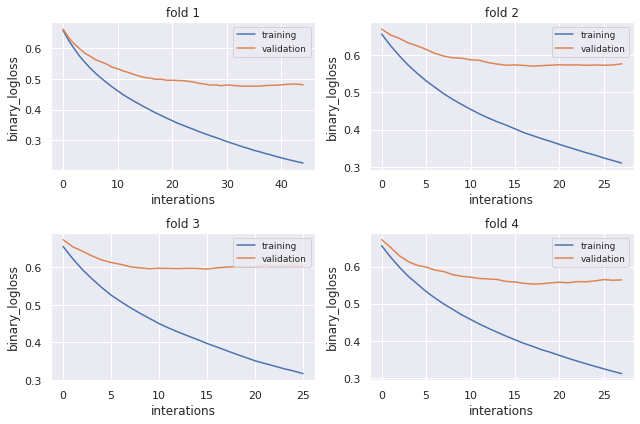

### CV scores by fold ###
fold 1: 0.4762
fold 2: 0.5707
fold 3: 0.5955
fold 4: 0.5529
fold 5: 0.5786
fold 6: 0.6201
fold 7: 0.5380
fold 8: 0.5449
fold 9: 0.4826
fold 10: 0.5456
CV mean score: 0.5505, std: 0.0429.
CPU times: user 6.47 s, sys: 184 ms, total: 6.66 s
Wall time: 3.93 s


In [ ]:
%%time
group_kfold = GroupKFold(n_splits=N_FOLDS)

feature_importance, test_pred = model_training(X, y, group_kfold, s, lgb_params, 'binary_logloss', plt_iter = True, X_test = X_test)

Text(0.5, 1.0, 'Feature Importnace')

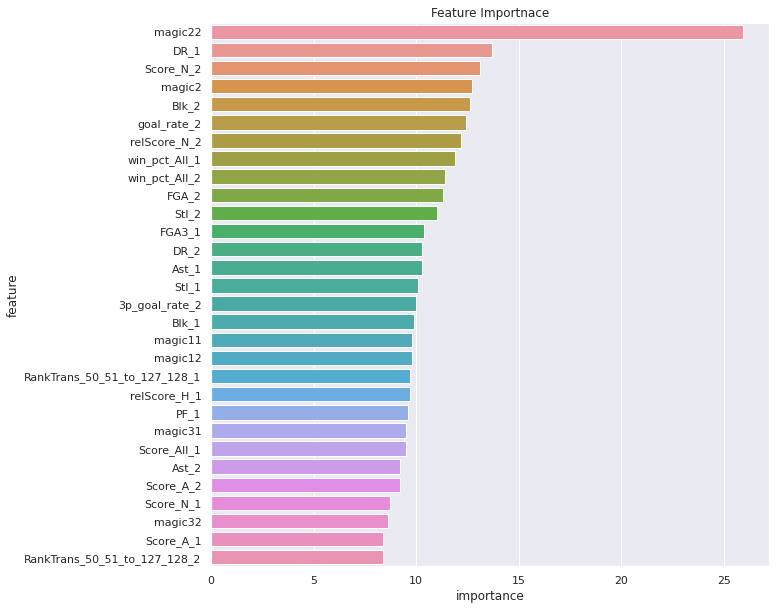

In [ ]:
plt.figure(figsize=(10, 10));
sns.barplot(x="importance", y="feature", data=feature_importance[:30])
plt.title('Feature Importnace')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm
import glob
import os
import gc
import xgboost as xgb

train = tourney
test = test

xgb_params= {
        "objective": "binary:logistic",
        "max_depth": 2,
        "learning_rate": 0.1,
        "colsample_bytree": 0.8,
        "subsample": 0.8,
        "min_child_weight": 30,
        "n_jobs": 2,
        "seed": 2021,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
        'predictor': 'gpu_predictor'
    }

y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

NUM_FOLDS = 5
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        print(len(train_ind), len(val_ind))
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        print(train_df)
        train_df_xgb = xgb.DMatrix(train_df, label=train_target)
        val_df_xgb = xgb.DMatrix(val_df, label=val_target)
        
        model = HistGradientBoostingClassifier(max_iter=max_iter, validation_fraction=None, learning_rate=0.01, max_depth=2, min_samples_leaf=32)
        model1 = RandomForestClassifier()
        model2 = LogisticRegression(C=1)
        model3 = xgb.train(xgb_params, train_df_xgb, 1000)

        model =  model.fit(train_df, train_target)
        model1 =  model1.fit(train_df, train_target)
        model2 =  model2.fit(train_df, train_target)
        
        temp_oof = (model.predict_proba(val_df)[:,1] + model1.predict_proba(val_df)[:,1] + model2.predict_proba(val_df)[:,1] + model3.predict(val_df_xgb)) / 4

        temp_test = (model.predict_proba(X_test)[:,1] + model1.predict_proba(X_test)[:,1] + model2.predict_proba(X_test)[:,1] + model3.predict(xgb.DMatrix(X_test))) / 4

        train_oof[val_ind] = temp_oof

        test_preds += temp_test / NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))
        
print('CV', log_loss(y, train_oof))        
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

test = test
MSampleSubmission = pd.read_csv(data + '/MSampleSubmissionStage2.csv')

idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub3 = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
pred_3 = sub3['Pred']


0it [00:00, ?it/s]

1706 524
      win_pct_A_1  win_pct_N_1  win_pct_H_1  win_pct_All_1  win_pct_A_2  \
64       0.200000     1.000000     0.666667       0.466667     0.357143   
65       0.400000     0.500000     0.733333       0.586207     0.846154   
66       0.600000     0.800000     0.944444       0.818182     0.666667   
67       0.636364     0.750000     0.733333       0.700000     0.545455   
68       0.800000     0.714286     0.933333       0.843750     0.357143   
...           ...          ...          ...            ...          ...   
2158     0.545455     0.833333     0.937500       0.787879     0.700000   
2159     0.400000     0.600000     0.944444       0.727273     0.750000   
2160     0.692308     1.000000     0.928571       0.843750     0.545455   
2161     0.700000     0.857143     0.823529       0.794118     0.750000   
2162     0.545455     0.857143     0.937500       0.794118     0.750000   

      win_pct_N_2  win_pct_H_2  win_pct_All_2  Score_A_1  relScore_A_1  ...  \
64       1.

In [ ]:
0.5539459504635523

0.5539459504635523

In [ ]:
idx = test_pred.shape[0] //2
test_pred[idx:] = 1 - test_pred[idx:]

pred = pd.concat([test.ID, pd.Series(test_pred)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub['Pred'] = sub['Pred'] * 0.3 + sub3['Pred'] * 0.7
sub.to_csv('submission.csv', index=False)
sub.head()

,ID,Pred
0,2021_1101_1104,0.296667
1,2021_1101_1111,0.805413
2,2021_1101_1116,0.268546
3,2021_1101_1124,0.152183
4,2021_1101_1140,0.482230


In [ ]:
if STAGE_1:
    rslt = pd.DataFrame()
    TCResults_s = TCResults.loc[TCResults.Season >= 2015,:]
    rslt['season'] = TCResults_s.Season
    rslt['team1'] = TCResults_s.apply(lambda x: x.WTeamID \
                                      if x.WTeamID < x.LTeamID else x.LTeamID
                                      , axis=1)
    rslt['team2'] = TCResults_s.apply(lambda x: x.WTeamID \
                                      if x.WTeamID > x.LTeamID else x.LTeamID
                                      , axis=1)
    rslt['wl'] = TCResults_s.apply(lambda x: 1 if x.WTeamID < x.LTeamID else 0
                                   , axis=1)
    rslt['ID'] = rslt.apply(lambda x: str(x.season) + '_' + str(x.team1) \
                            + '_' + str(x.team2), axis=1)
    sub2 = sub.merge(rslt.loc[:,['ID','wl']], how='inner', on='ID')

    preds = []
    for i in sub2.Pred:
        preds.append([1-i, i])

    print('Test logloss is {:.5f}'.format(log_loss(sub2.wl.values, preds)))

In [ ]:
0.51971

0.51971

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 21.2 MB/s 
     |████████████████████████████████| 272 kB 49.3 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 2.3 MB 63.6 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 140 kB 74.8 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 57 kB 4.4 MB/s 
     |████████████████████████████████| 212 kB 70.7 MB/s 
     |████████████████████████████████| 271 kB 74.1 MB/s 
     |████████████████████████████████| 144 kB 74.4 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 80 kB

In [ ]:
sub

,ID,Pred
0,2021_1101_1104,0.296667
1,2021_1101_1111,0.805413
2,2021_1101_1116,0.268546
3,2021_1101_1124,0.152183
4,2021_1101_1140,0.482230
...,...,...
2273,2021_1452_1457,0.579892
2274,2021_1452_1458,0.423869
2275,2021_1455_1457,0.343938
2276,2021_1455_1458,0.280843


In [ ]:
import gradio as gr

In [ ]:
def prediction_result(teamID_1, teamID_2):
    id = f"2021_{int(teamID_1)}_{int(teamID_2)}"
    pred = sub["Pred"].loc[sub["ID"] == id]
    p = pred.values
    return f"The winning probability of teamID {int(teamID_1)} is {round(p[0] * 100, 2)}%"

demo = gr.Interface(
    fn = prediction_result,
    inputs = ["number", "number"],
    outputs = "text", 
    title = "MENS MARCH MANIA 2021",
    description = """Predicted the outcome of the 2021 tournament""",
    examples = [[1101, 1104], [1101, 1111], [1101, 1116], [1101, 1124], [1101, 1140]],
    live = True,
    css = 'body{background-image:url("https://d2jx2rerrg6sh3.cloudfront.net/image-handler/picture/2016/5/3d_rendered_illustration_-_heart_attack-Sebastian_Kaulitzki_d8743c68eb3c4250817a2a23a847caeb-620x480.jpg");'
)

demo.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://46485.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7fe94dcc5c50>,
 'http://127.0.0.1:7860/',
 'https://46485.gradio.app')

In [ ]:
!git clone https://huggingface.co/spaces/Harshi/MarchMachineLearningMania

Cloning into 'MarchMachineLearningMania'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.
